# Задача

### Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

### Практика основана на соревновании [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (Прогнозирование биологического ответа) Каждая строка представляет молекулу:

- столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
- столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

#### Предварительная обработка не требуется, данные уже закодированы и нормализованы. В качестве метрики будем использовать F1-score.

#### Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [70]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import plotly
from skimpy import skim # для продвинутого вывода статистической информации

from sklearn import linear_model #линейные моделиё
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

import warnings
warnings.filterwarnings('ignore') # отключаем уведомления системы

%matplotlib inline
plt.style.use('seaborn')

In [39]:
RANDOM_STATE = 42

# Знакомство с данными

## Чтение данных

In [40]:
url = 'https://lms.skillfactory.ru/assets/courseware/v1/9f2add5bca59f8c4df927432d605fff3/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/_train_sem09__1_.zip'
data = pd.read_csv(url)

data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


## Исследование данных

### Наличие пропусков

In [41]:
data.isnull().sum()

Activity    0
D1          0
D2          0
D3          0
D4          0
           ..
D1772       0
D1773       0
D1774       0
D1775       0
D1776       0
Length: 1777, dtype: int64

#### Пропусков нет

### Статистические данные датасета

In [42]:
data.describe()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,...,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.542255,0.076948,0.592436,0.068142,0.038990,0.212112,0.686653,0.274713,0.455133,0.749517,...,0.026926,0.014663,0.013863,0.021861,0.015196,0.016796,0.012263,0.011730,0.020261,0.011197
std,0.498278,0.079989,0.105860,0.078414,0.115885,0.102592,0.078702,0.090017,0.162731,0.071702,...,0.161889,0.120215,0.116938,0.146249,0.122348,0.128522,0.110074,0.107683,0.140911,0.105236
min,0.000000,0.000000,0.282128,0.000000,0.000000,0.002630,0.137873,0.006130,0.000000,0.275590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.033300,0.517811,0.000000,0.000000,0.138118,0.625627,0.207374,0.378062,0.707339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.066700,0.585989,0.050000,0.000000,0.190926,0.674037,0.277845,0.499942,0.738961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.100000,0.668395,0.100000,0.000000,0.261726,0.740663,0.335816,0.569962,0.788177,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.964381,0.950000,1.000000,1.000000,0.994735,0.790831,0.989870,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Сбалансированность

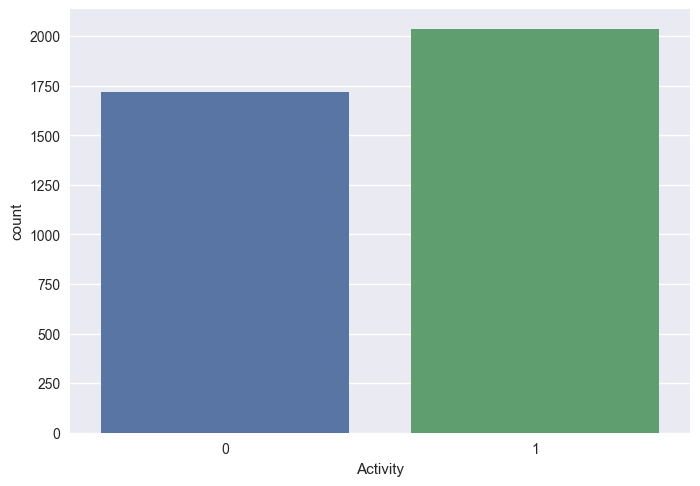

In [43]:
sns.countplot(data=data, x='Activity');

### Матрица наблюдений и разделение датасета

In [44]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = 0.2)

## **Предсказание без оптимизации гиперпараметров**

#### Логистическая регрессия

In [45]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


#### Случайный лес

In [46]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=RANDOM_STATE)

#Обучаем модель
rf.fit(X_train, y_train)

#Выводим значения метрики 
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.83


## **Подбор гиперпараметров**

### <center> **GridSearchCV**

#### Логистическая регрессия

In [47]:
# Логистическая регрессия
param_gs = [
    {
        'penalty': ['l2', 'none'] , # тип регуляризации
        'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
    {
        'penalty': ['l1', 'l2'] ,
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_gs, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
f1_lr_gs = metrics.f1_score(y_test, y_test_pred)
print('f1_score на тестовом наборе: {:.2f}'.format(f1_lr_gs))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 2.42 s
Wall time: 9min 36s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


**Вывод**
Метрика не улучшилась

#### Случайный лес

In [48]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 1.12 s
Wall time: 30.3 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.84
Наилучшие значения гиперпараметров: {'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 140}


**Вывод**
Метрика немного улучшилась

## <center> **RandomizedSearchCV**

#### Логистическая регрессия

In [49]:
param_distributions = {
                       'penalty': ['l2', 'none'],
                       'solver': ['lbfgs', 'sag'],
                       'C': list(np.linspace(0.01, 1, 10, dtype=float))
                       }
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 1.39 s
Wall time: 1min 26s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.12}


**Вывод**
Метрика не улучшилась, но на подбор гиперпараметров ушло существенно меньше времени

#### Случайный лес

In [50]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 1.38 s
Wall time: 16.3 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': 24}


**Вывод**
Метрика несущественно, но ухудшилась, зато на подбор гиперпараметров ушло существенно меньше времени

## <center> **Hyperopt**

#### Логистическая регрессия

In [51]:
space_lr={'penalty':hp.choice(label='penalty', options=['l2', 'none']),
       'C':hp.loguniform(label='C',  low=-4*np.log(10), high=2*np.log(10)),
       'solver' : hp.choice(label='solver', options=['lbfgs','saga']),
      }


def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):
    
    params = {'penalty': str(params['penalty']), 
              'solver': str(params['solver']), 
              'C': float(params['C'])
              }
  
    # строим модель
    model = linear_model.LogisticRegression(**params, max_iter = 50, random_state=RANDOM_STATE)

    # обучаем модель
    model.fit(X, y)
        
    # применим cross-validation
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # возвращаем отрицательное значение метрики
    return -score


# начинаем подбор гиперпараметров
trials = Trials()

best_lr=fmin(hyperopt_lr, # наша функция 
          space=space_lr, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(RANDOM_STATE)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best_lr))

model_lr = linear_model.LogisticRegression(
    random_state=RANDOM_STATE, 
    penalty='l2' if best_lr['penalty'] == 0 else 'none',
    solver='lbfgs'if best_lr['solver'] == 0 else 'saga',
    C=best_lr['C']
)
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model_lr.score(X_test, y_test)))
y_test_pred = model_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [01:02<00:00,  3.13s/trial, best loss: -0.7848818300699648]
Наилучшие значения гиперпараметров {'C': 0.06351720730956673, 'penalty': 0, 'solver': 1}
f1_score на обучающем наборе: 0.84
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79


**Вывод**
Так же не удалось улучшить метрику

#### Случайный лес

In [52]:
space_rf={'n_estimators': hp.quniform('n_estimators', 80, 200, 30),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    model = ensemble.RandomForestClassifier(**params, random_state=RANDOM_STATE)

    # обучаем модель
    model.fit(X, y)

    # применяем кросс-валидацию
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return -score


trials = Trials()
best_rf=fmin(hyperopt_rf, # наша функция 
          space=space_rf, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(RANDOM_STATE)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best_rf))

model_rf = ensemble.RandomForestClassifier(
    random_state=RANDOM_STATE, 
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf'])
)
model_rf.fit(X_train, y_train)
y_train_pred = model_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model_rf.score(X_test, y_test)))
y_test_pred = model_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 50/50 [05:38<00:00,  6.76s/trial, best loss: -0.8129520976582258]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 210.0}
f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.83


**Вывод**
Метрика стала немного хуже

### **Визуализация процесс подбора методом Hyperopt**

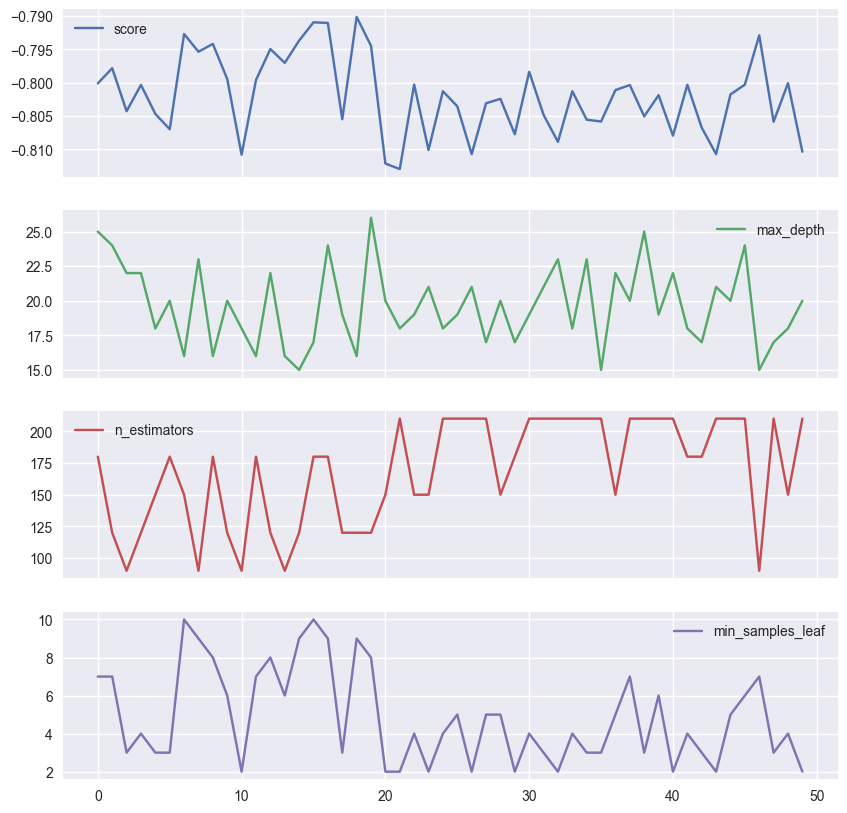

In [53]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0],
                       x['misc']['vals']['min_samples_leaf'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators', 'min_samples_leaf'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

### <center> **Optuna**

#### Логистическая регрессия

In [56]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['none', 'l2'])
  C = trial.suggest_float('C', 0.01, 1)
  solver = trial.suggest_categorical('solver', ['saga', 'lbfgs'])

  # создаем модель
  model = linear_model.LogisticRegression(solver=solver,
                                          penalty=penalty,
                                          C=C,
                                          max_iter=50,
                                          random_state=RANDOM_STATE)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")

study_lr.optimize(optuna_lr, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study_lr.best_params))


model_lr = linear_model.LogisticRegression(**study_lr.best_params,random_state=RANDOM_STATE, max_iter=50)
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict(X_train)
print('f1_score на тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model_lr.predict(X_test)
print('f1_score на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


[I 2023-09-21 06:30:52,382] A new study created in memory with name: LogisticRegression
[I 2023-09-21 06:30:59,959] Trial 0 finished with value: 0.7786806815965137 and parameters: {'penalty': 'none', 'C': 0.3011457160643931, 'solver': 'saga'}. Best is trial 0 with value: 0.7786806815965137.
[I 2023-09-21 06:31:02,230] Trial 1 finished with value: 0.7725014263530248 and parameters: {'penalty': 'l2', 'C': 0.9570349246115474, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7786806815965137.
[I 2023-09-21 06:31:08,909] Trial 2 finished with value: 0.7786806815965137 and parameters: {'penalty': 'none', 'C': 0.16835726687035463, 'solver': 'saga'}. Best is trial 0 with value: 0.7786806815965137.
[I 2023-09-21 06:31:14,728] Trial 3 finished with value: 0.7786806815965137 and parameters: {'penalty': 'none', 'C': 0.5817785198895505, 'solver': 'saga'}. Best is trial 0 with value: 0.7786806815965137.
[I 2023-09-21 06:31:15,905] Trial 4 finished with value: 0.7604610029817153 and parameters: {'pe

Наилучшие значения гиперпараметров {'penalty': 'l2', 'C': 0.02959146374071231, 'solver': 'lbfgs'}
f1_score на тренировочной выборке: 0.83
f1_score на тестовой выборке: 0.80


**Вывод**
Метрика улучшилась, но не существенно

#### Случайный лес

In [57]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=RANDOM_STATE)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study_rf.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))

model_rf = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=RANDOM_STATE)
model_rf.fit(X_train, y_train)
print("f1_score на тренировочной выборке: {:.2f}".format(model_rf.score(X_train, y_train)))
print("f1_score на тестовой выборке: {:.2f}".format(model_rf.score(X_test, y_test)))

[I 2023-09-21 06:31:42,863] A new study created in memory with name: RandomForestClassifier
[I 2023-09-21 06:31:50,095] Trial 0 finished with value: 0.7960535698704304 and parameters: {'n_estimators': 192, 'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7960535698704304.
[I 2023-09-21 06:31:57,988] Trial 1 finished with value: 0.8033113813406502 and parameters: {'n_estimators': 186, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8033113813406502.
[I 2023-09-21 06:32:06,037] Trial 2 finished with value: 0.8106427513566619 and parameters: {'n_estimators': 170, 'max_depth': 17, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8106427513566619.
[I 2023-09-21 06:32:12,695] Trial 3 finished with value: 0.8064786422224375 and parameters: {'n_estimators': 163, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8106427513566619.
[I 2023-09-21 06:32:18,059] Trial 4 finished with value: 0.7956300587601352 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 136, 'max_depth': 16, 'min_samples_leaf': 2}
f1_score на тренировочной выборке: 0.98
f1_score на тестовой выборке: 0.80


**Вывод**
Метрика ухудшилась, поэтому продолжим подбор гиперпараметров

In [72]:
study_rf.optimize(optuna_rf, n_trials=10)

[I 2023-09-21 06:51:06,620] Trial 20 finished with value: 0.8141430939857202 and parameters: {'n_estimators': 126, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 12 with value: 0.8162433827661137.
[I 2023-09-21 06:51:14,749] Trial 21 finished with value: 0.8141430939857202 and parameters: {'n_estimators': 126, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 12 with value: 0.8162433827661137.
[I 2023-09-21 06:51:21,653] Trial 22 finished with value: 0.8117689182159193 and parameters: {'n_estimators': 116, 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 12 with value: 0.8162433827661137.
[I 2023-09-21 06:51:28,889] Trial 23 finished with value: 0.8159891202966941 and parameters: {'n_estimators': 133, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 12 with value: 0.8162433827661137.
[I 2023-09-21 06:51:36,449] Trial 24 finished with value: 0.8110629626162105 and parameters: {'n_estimators': 150, 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 12 with va

In [73]:
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))

model_rf = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=RANDOM_STATE)
model_rf.fit(X_train, y_train)
print("f1_score на тренировочной выборке: {:.2f}".format(model_rf.score(X_train, y_train)))
print("f1_score на тестовой выборке: {:.2f}".format(model_rf.score(X_test, y_test)))

Наилучшие значения гиперпараметров {'n_estimators': 156, 'max_depth': 27, 'min_samples_leaf': 2}
f1_score на тренировочной выборке: 0.99
f1_score на тестовой выборке: 0.80


**Вывод**
И вновь улучшения метрики не случилось

**Выводы**
Использование ни одного из методов по оптимизации гиперпараметров не привело к к какому-либо существенному улучшению качества модели как логистиеской регресииЮ, так и случайного леса. К огоромному сожалению, так как очень хотелось бы увидеть работу этих фреймворков в рамках учебного процесса, а в результате пока вижу их бесполезность